In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
from matplotlib.pylab import rcParams

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
signalFile=TFile.Open("../samples/sig_nonres_bbtt.root")
backgroundFile=TFile.Open("../samples/sig_nonres_bbww.root")

In [3]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  217248
background events number before cut is:  84531


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(217248, 22)


In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

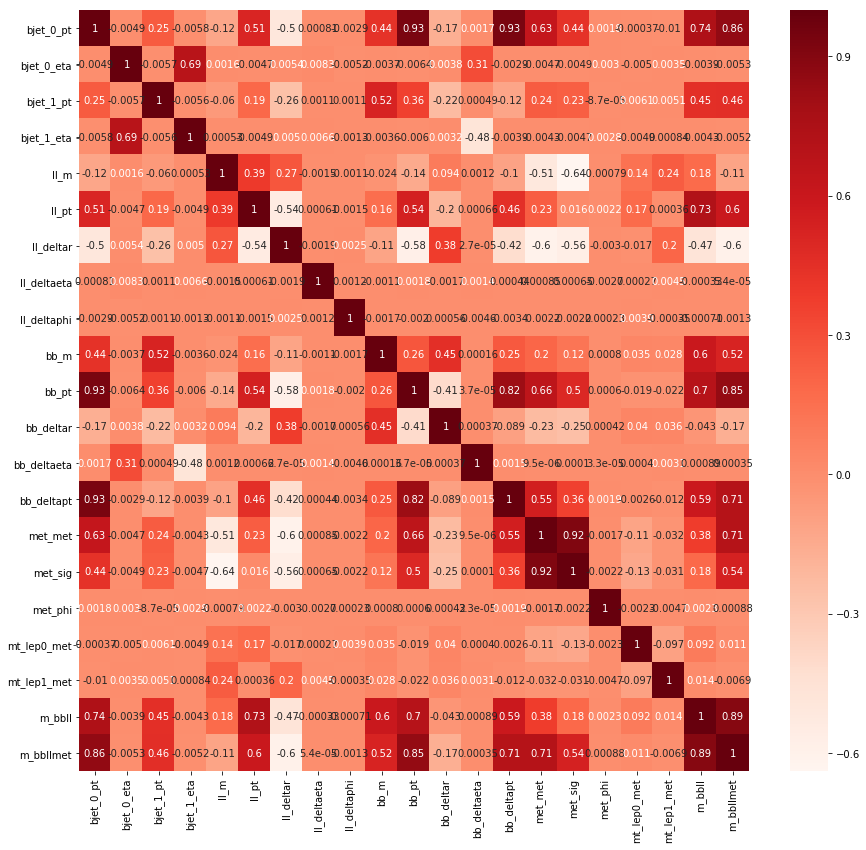

In [7]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

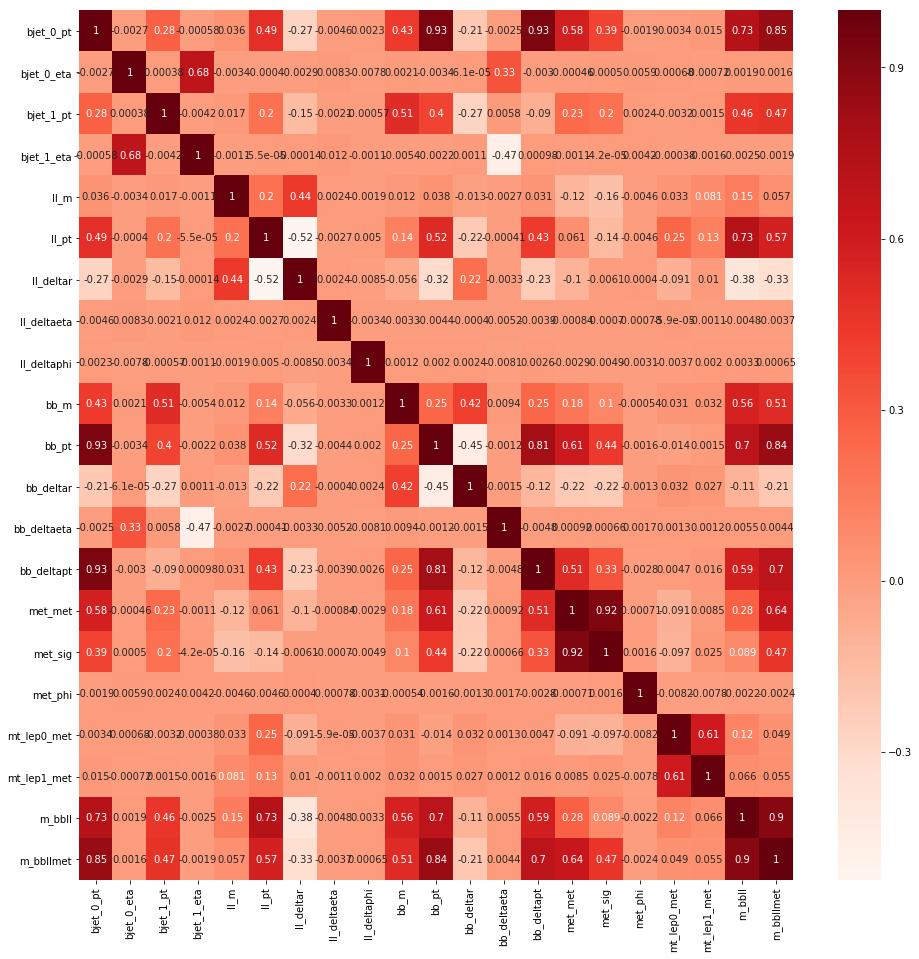

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [9]:
print(signalArray)

[[ 5.99125689e-08  3.43779406e+05 -8.89795244e-01 ...  8.16832910e+03
   1.01459575e+06  1.15864900e+06]
 [ 1.37623146e-05  2.02115812e+05 -1.13858283e+00 ...  4.82755898e+04
   4.13342219e+05  5.49812625e+05]
 [ 1.21445784e-06  2.04746391e+05  1.65332592e+00 ...  2.39445947e+03
   4.90221562e+05  9.90220812e+05]
 ...
 [ 3.69084698e-05  9.59073438e+04 -1.60544014e+00 ...  1.28037285e+04
   2.70796531e+05  3.64658312e+05]
 [ 4.55069750e-06  2.05500875e+05  5.38439453e-01 ...  1.36688916e+04
   5.46038250e+05  6.63057375e+05]
 [ 1.65528623e-06  2.39564734e+05 -1.39261913e+00 ...  3.73748608e+03
   4.83871188e+05  1.09625988e+06]]


In [10]:
print(signalArray[:,1])

[343779.40625  202115.8125   204746.390625 ...  95907.34375  205500.875
 239564.734375]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

217248
84531


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  217248
background event number after cut is: 84531


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  195523
testing signal events number is:  21725
training background events number is:  76077
testing background events number is:  8454


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[ 0.00000000e+00  9.37469647e-07  5.14574219e+05 ...  5.41074805e+03
   5.92071188e+05  1.33082400e+06]
 [ 0.00000000e+00  1.29087278e-05  2.08606938e+05 ...  3.41941602e+04
   5.17863094e+05  7.85121688e+05]
 [ 0.00000000e+00  2.94686345e-06  1.90935219e+05 ...  4.44491680e+04
   9.06244500e+05  9.75508000e+05]
 ...
 [ 0.00000000e+00  1.43718319e-06  5.30011562e+05 ...  3.61979766e+04
   1.20236425e+06  1.39116412e+06]
 [ 0.00000000e+00 -1.49778824e-04  1.34437922e+05 ...  8.31923125e+04
   2.70497562e+05  4.58387844e+05]
 [ 0.00000000e+00  6.86499316e-06  1.76849109e+05 ...  5.30523867e+04
   4.77484812e+05  8.07346125e+05]]
0.34229338843866475


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(271600, 21) dtype=float32>

Signal and background training sets should have same yield in training

(271600,)
(271600,)


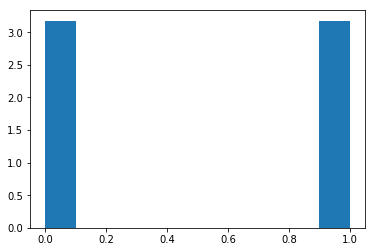

In [17]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [18]:
traindf=pd.DataFrame(data=dataTrainSample)
normalize_df=(traindf-traindf.min())/(traindf.max()-traindf.min())
dataTrainSample1=normalize_df.values
print(dataTrainSample1)

[[0.07487438 0.60070051 0.06656997 ... 0.00091527 0.04813032 0.07426288]
 [0.18102672 0.19395032 0.01553021 ... 0.00737348 0.09917034 0.16202823]
 [0.08548455 0.36002925 0.05014873 ... 0.02105359 0.08678224 0.0960516 ]
 ...
 [0.0806765  0.25935927 0.07473067 ... 0.01353951 0.03327853 0.07726513]
 [0.02855056 0.29085759 0.01504193 ... 0.00913711 0.01492113 0.02413118]
 [0.04756442 0.38015214 0.04788354 ... 0.01063874 0.02082402 0.05381567]]


In [19]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     optimizer=Adam(lr=1e-4, beta_1=0.6, beta_2=0.8, epsilon=None, decay=0.0, amsgrad=False),
      #optimizer='adam',
     metrics=["acc"])

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [21]:
model.save('../NN_model/model_tt-ww.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

2019-06-30 23:33:54.364002: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-06-30 23:33:54.367410: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3600000000 Hz
2019-06-30 23:33:54.367923: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x563a698aa3c0 executing computations on platform Host. Devices:
2019-06-30 23:33:54.367940: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-30 23:33:54.444223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-30 23:33:54.444697: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x563a689d1dc0 executing computations on platform CUDA. Devices:
2019-06-30 23:33:54.444710: I t

In [22]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
271600/271600 [==============================] - 13s 50us/sample - loss: 0.4258 - acc: 0.8247
Epoch 2/30
271600/271600 [==============================] - 13s 48us/sample - loss: 0.3410 - acc: 0.8547
Epoch 3/30
271600/271600 [==============================] - 13s 48us/sample - loss: 0.3457 - acc: 0.8560
Epoch 4/30
271600/271600 [==============================] - 13s 48us/sample - loss: 0.3925 - acc: 0.8639
Epoch 5/30
271600/271600 [==============================] - 13s 48us/sample - loss: 0.3658 - acc: 0.8674
Epoch 6/30
271600/271600 [==============================] - 13s 48us/sample - loss: 0.3251 - acc: 0.8683
Epoch 7/30
271600/271600 [==============================] - 13s 48us/sample - loss: 0.2787 - acc: 0.8702
Epoch 8/30
271600/271600 [==============================] - 13s 48us/sample - loss: 0.3408 - acc: 0.8716
Epoch 9/30
271600/271600 [==============================] - 13s 48us/sample - loss: 0.2990 - acc: 0.8748
Epoch 1

2019-06-30 23:33:56.120241: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


In [23]:
signaldf=pd.DataFrame(data=signalSample[:,1:])
normalize_df=(signaldf-signaldf.min())/(signaldf.max()-signaldf.min())
signalSample1=normalize_df.values
print(dataTrainSample1)
backgrounddf=pd.DataFrame(data=backgroundSample[:,1:])
normalize_df=(backgrounddf-backgrounddf.min())/(backgrounddf.max()-backgrounddf.min())
backgroundSample1=normalize_df.values
print(backgroundSample1)

[[0.07487438 0.60070051 0.06656997 ... 0.00091527 0.04813032 0.07426288]
 [0.18102672 0.19395032 0.01553021 ... 0.00737348 0.09917034 0.16202823]
 [0.08548455 0.36002925 0.05014873 ... 0.02105359 0.08678224 0.0960516 ]
 ...
 [0.0806765  0.25935927 0.07473067 ... 0.01353951 0.03327853 0.07726513]
 [0.02855056 0.29085759 0.01504193 ... 0.00913711 0.01492113 0.02413118]
 [0.04756442 0.38015214 0.04788354 ... 0.01063874 0.02082402 0.05381567]]
[[0.07004463 0.94552173 0.04731705 ... 0.00909984 0.09376527 0.10327342]
 [0.01386069 0.1298366  0.00676556 ... 0.00190841 0.0357241  0.03199467]
 [0.02983529 0.37495463 0.0255405  ... 0.01119477 0.03766587 0.04339296]
 ...
 [0.09895161 0.43232283 0.01286201 ... 0.0191164  0.07042464 0.08021703]
 [0.06471209 0.24632693 0.05258165 ... 0.01577829 0.0722067  0.08112853]
 [0.06325177 0.0894368  0.05645166 ... 0.04125144 0.05156577 0.0865338 ]]


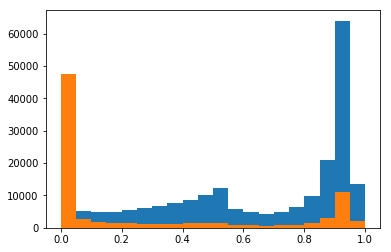

In [24]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

(array([47643.,  2672.,  1900.,  1502.,  1339.,  1186.,  1261.,  1314.,
         1365.,  1433.,  1413.,   915.,   774.,   681.,   778.,  1000.,
         1430.,  2987., 10968.,  1970.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

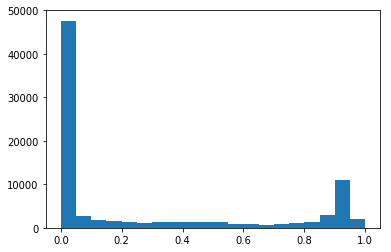

In [25]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [26]:
model.save('../NN_model/model_tt-ww-final.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

In [27]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

[[0.00508675]
 [0.8423575 ]
 [0.95316035]
 ...
 [0.9188814 ]
 [0.9755482 ]
 [0.92592746]]


(array([11192.,  5075.,  4897.,  4926.,  5417.,  6061.,  6880.,  7582.,
         8491., 10115., 12369.,  5675.,  4817.,  4412.,  4956.,  6411.,
         9676., 20819., 63975., 13502.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

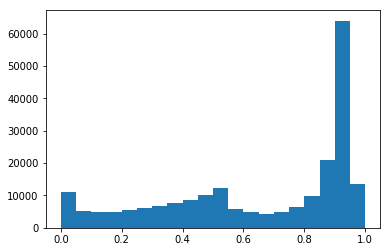

In [28]:
plt.hist(signalNNScore,bins=20)

In [29]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=1e-4, beta_1=0.6, beta_2=0.8, epsilon=None, decay=0.0, amsgrad=False),
        #optimizer='adam',
        metrics=["acc"])
    return model

In [30]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=10, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)
eli5.show_weights(perm,feature_names=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [31]:
cuda.select_device(0)
cuda.close()

In [32]:
traindf=pd.DataFrame(data=dataTrainSample)
normalize_df=(traindf-traindf.min())/(traindf.max()-traindf.min())
dataTrainSample1=normalize_df.values
print(dataTrainSample1)

testdf=pd.DataFrame(data=dataTestSample)
normalize_df=(testdf-testdf.min())/(testdf.max()-testdf.min())
dataTestSample1=normalize_df.values
print(dataTestSample1)


[[0.07487438 0.60070051 0.06656997 ... 0.00091527 0.04813032 0.07426288]
 [0.18102672 0.19395032 0.01553021 ... 0.00737348 0.09917034 0.16202823]
 [0.08548455 0.36002925 0.05014873 ... 0.02105359 0.08678224 0.0960516 ]
 ...
 [0.0806765  0.25935927 0.07473067 ... 0.01353951 0.03327853 0.07726513]
 [0.02855056 0.29085759 0.01504193 ... 0.00913711 0.01492113 0.02413118]
 [0.04756442 0.38015214 0.04788354 ... 0.01063874 0.02082402 0.05381567]]
[[0.05153794 0.44726027 0.02453879 ... 0.0652839  0.0498858  0.04735645]
 [0.18147633 0.67237093 0.07213487 ... 0.01055349 0.10179256 0.14100957]
 [0.06713247 0.78061607 0.09615643 ... 0.13335306 0.08425801 0.09375768]
 ...
 [0.0696308  0.60794065 0.0295425  ... 0.07299256 0.03154381 0.04699212]
 [0.05885049 0.18326593 0.08047838 ... 0.14367429 0.04758675 0.10064122]
 [0.01511951 0.88384447 0.00689718 ... 0.07546634 0.01957964 0.0261844 ]]


In [42]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample1,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample1,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
param = {'max_depth': 1, 'eta': 1.0, 'silent': 0, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_exact'
param['grow_policy'] = 'lossguide'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [43]:
num_round = 500
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.742842	train-auc:0.740883
[1]	eval-auc:0.777722	train-auc:0.781842
[2]	eval-auc:0.779288	train-auc:0.784314
[3]	eval-auc:0.787986	train-auc:0.79298
[4]	eval-auc:0.789393	train-auc:0.795118
[5]	eval-auc:0.797365	train-auc:0.810099
[6]	eval-auc:0.799454	train-auc:0.811203
[7]	eval-auc:0.800881	train-auc:0.813084
[8]	eval-auc:0.802565	train-auc:0.814465
[9]	eval-auc:0.812967	train-auc:0.826273
[10]	eval-auc:0.822959	train-auc:0.833972
[11]	eval-auc:0.825893	train-auc:0.840906
[12]	eval-auc:0.825956	train-auc:0.840692
[13]	eval-auc:0.828528	train-auc:0.843157
[14]	eval-auc:0.834347	train-auc:0.848883
[15]	eval-auc:0.833689	train-auc:0.849155
[16]	eval-auc:0.837525	train-auc:0.852152
[17]	eval-auc:0.837697	train-auc:0.852348
[18]	eval-auc:0.837684	train-auc:0.852138
[19]	eval-auc:0.839752	train-auc:0.853715
[20]	eval-auc:0.842838	train-auc:0.856882
[21]	eval-auc:0.842934	train-auc:0.857505
[22]	eval-auc:0.842372	train-auc:0.856872
[23]	eval-auc:0.843461	train-auc:0.85721
[24]

[195]	eval-auc:0.876398	train-auc:0.888207
[196]	eval-auc:0.876388	train-auc:0.888189
[197]	eval-auc:0.876361	train-auc:0.888211
[198]	eval-auc:0.876451	train-auc:0.888266
[199]	eval-auc:0.876515	train-auc:0.888308
[200]	eval-auc:0.876506	train-auc:0.888291
[201]	eval-auc:0.876536	train-auc:0.888319
[202]	eval-auc:0.876547	train-auc:0.888395
[203]	eval-auc:0.876524	train-auc:0.888406
[204]	eval-auc:0.876514	train-auc:0.88839
[205]	eval-auc:0.876562	train-auc:0.88843
[206]	eval-auc:0.87665	train-auc:0.888494
[207]	eval-auc:0.876682	train-auc:0.88852
[208]	eval-auc:0.876672	train-auc:0.888503
[209]	eval-auc:0.876716	train-auc:0.888541
[210]	eval-auc:0.876703	train-auc:0.888524
[211]	eval-auc:0.876752	train-auc:0.888549
[212]	eval-auc:0.876801	train-auc:0.888596
[213]	eval-auc:0.876851	train-auc:0.888635
[214]	eval-auc:0.87684	train-auc:0.888618
[215]	eval-auc:0.876885	train-auc:0.888643
[216]	eval-auc:0.876875	train-auc:0.888627
[217]	eval-auc:0.876914	train-auc:0.888666
[218]	eval-auc:0

[387]	eval-auc:0.880075	train-auc:0.890502
[388]	eval-auc:0.880074	train-auc:0.890498
[389]	eval-auc:0.880092	train-auc:0.89051
[390]	eval-auc:0.880088	train-auc:0.890506
[391]	eval-auc:0.880109	train-auc:0.890513
[392]	eval-auc:0.880107	train-auc:0.890509
[393]	eval-auc:0.880125	train-auc:0.890522
[394]	eval-auc:0.880123	train-auc:0.890518
[395]	eval-auc:0.880133	train-auc:0.890525
[396]	eval-auc:0.880132	train-auc:0.890521
[397]	eval-auc:0.88015	train-auc:0.890534
[398]	eval-auc:0.880149	train-auc:0.890531
[399]	eval-auc:0.880159	train-auc:0.890538
[400]	eval-auc:0.880158	train-auc:0.890535
[401]	eval-auc:0.880176	train-auc:0.890549
[402]	eval-auc:0.880213	train-auc:0.890558
[403]	eval-auc:0.880205	train-auc:0.890565
[404]	eval-auc:0.880203	train-auc:0.890562
[405]	eval-auc:0.880217	train-auc:0.890574
[406]	eval-auc:0.880215	train-auc:0.89057
[407]	eval-auc:0.880228	train-auc:0.890577
[408]	eval-auc:0.880225	train-auc:0.890572
[409]	eval-auc:0.880231	train-auc:0.890585
[410]	eval-auc

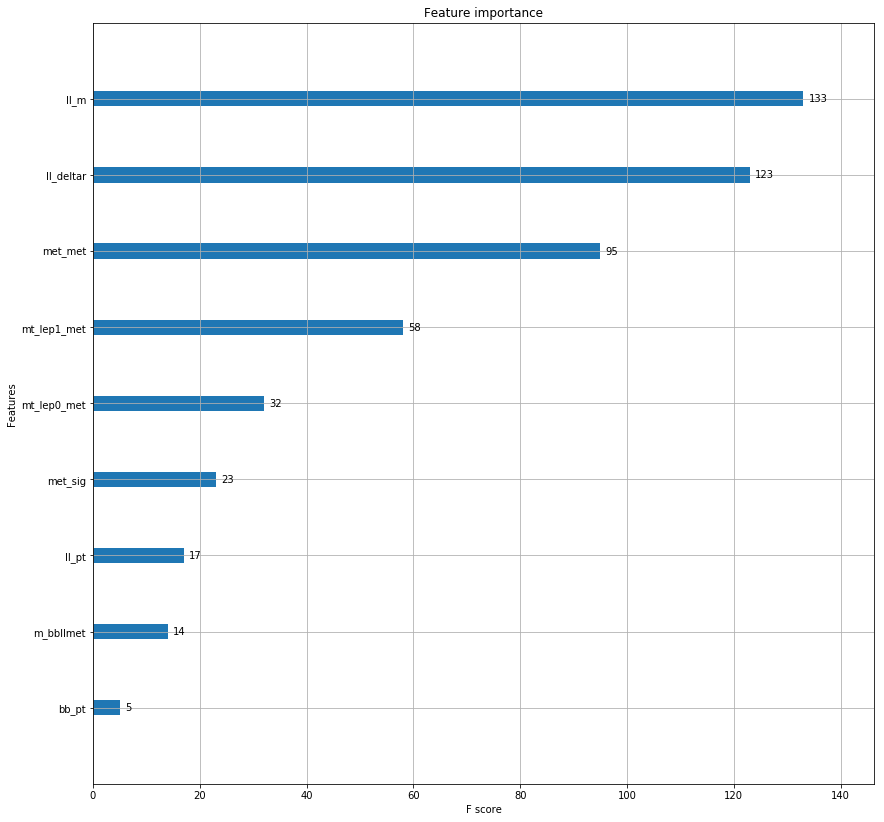

In [44]:
fig, ax = plt.subplots(figsize=(14, 14))
xgb.plot_importance(GBDT,ax=ax)

In [ ]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

In [ ]:
plt.hist(SignalScore,bins=20)

In [ ]:
plot_tree(GBDT, num_trees=4)

(array([21781.,  9413.,  6355.,  6063.,  6969.,  8426.,  8133.,  9447.,
         9463., 11576., 15532., 18967., 20301., 23457., 22328., 20913.,
        17772., 14985., 13466.,  6253.]),
 array([0.00141031, 0.05122482, 0.10103934, 0.15085384, 0.20066835,
        0.25048286, 0.30029738, 0.35011187, 0.3999264 , 0.44974092,
        0.4995554 , 0.54936993, 0.59918445, 0.6489989 , 0.69881344,
        0.74862796, 0.7984425 , 0.848257  , 0.89807147, 0.947886  ,
        0.9977005 ], dtype=float32),
 <a list of 20 Patch objects>)

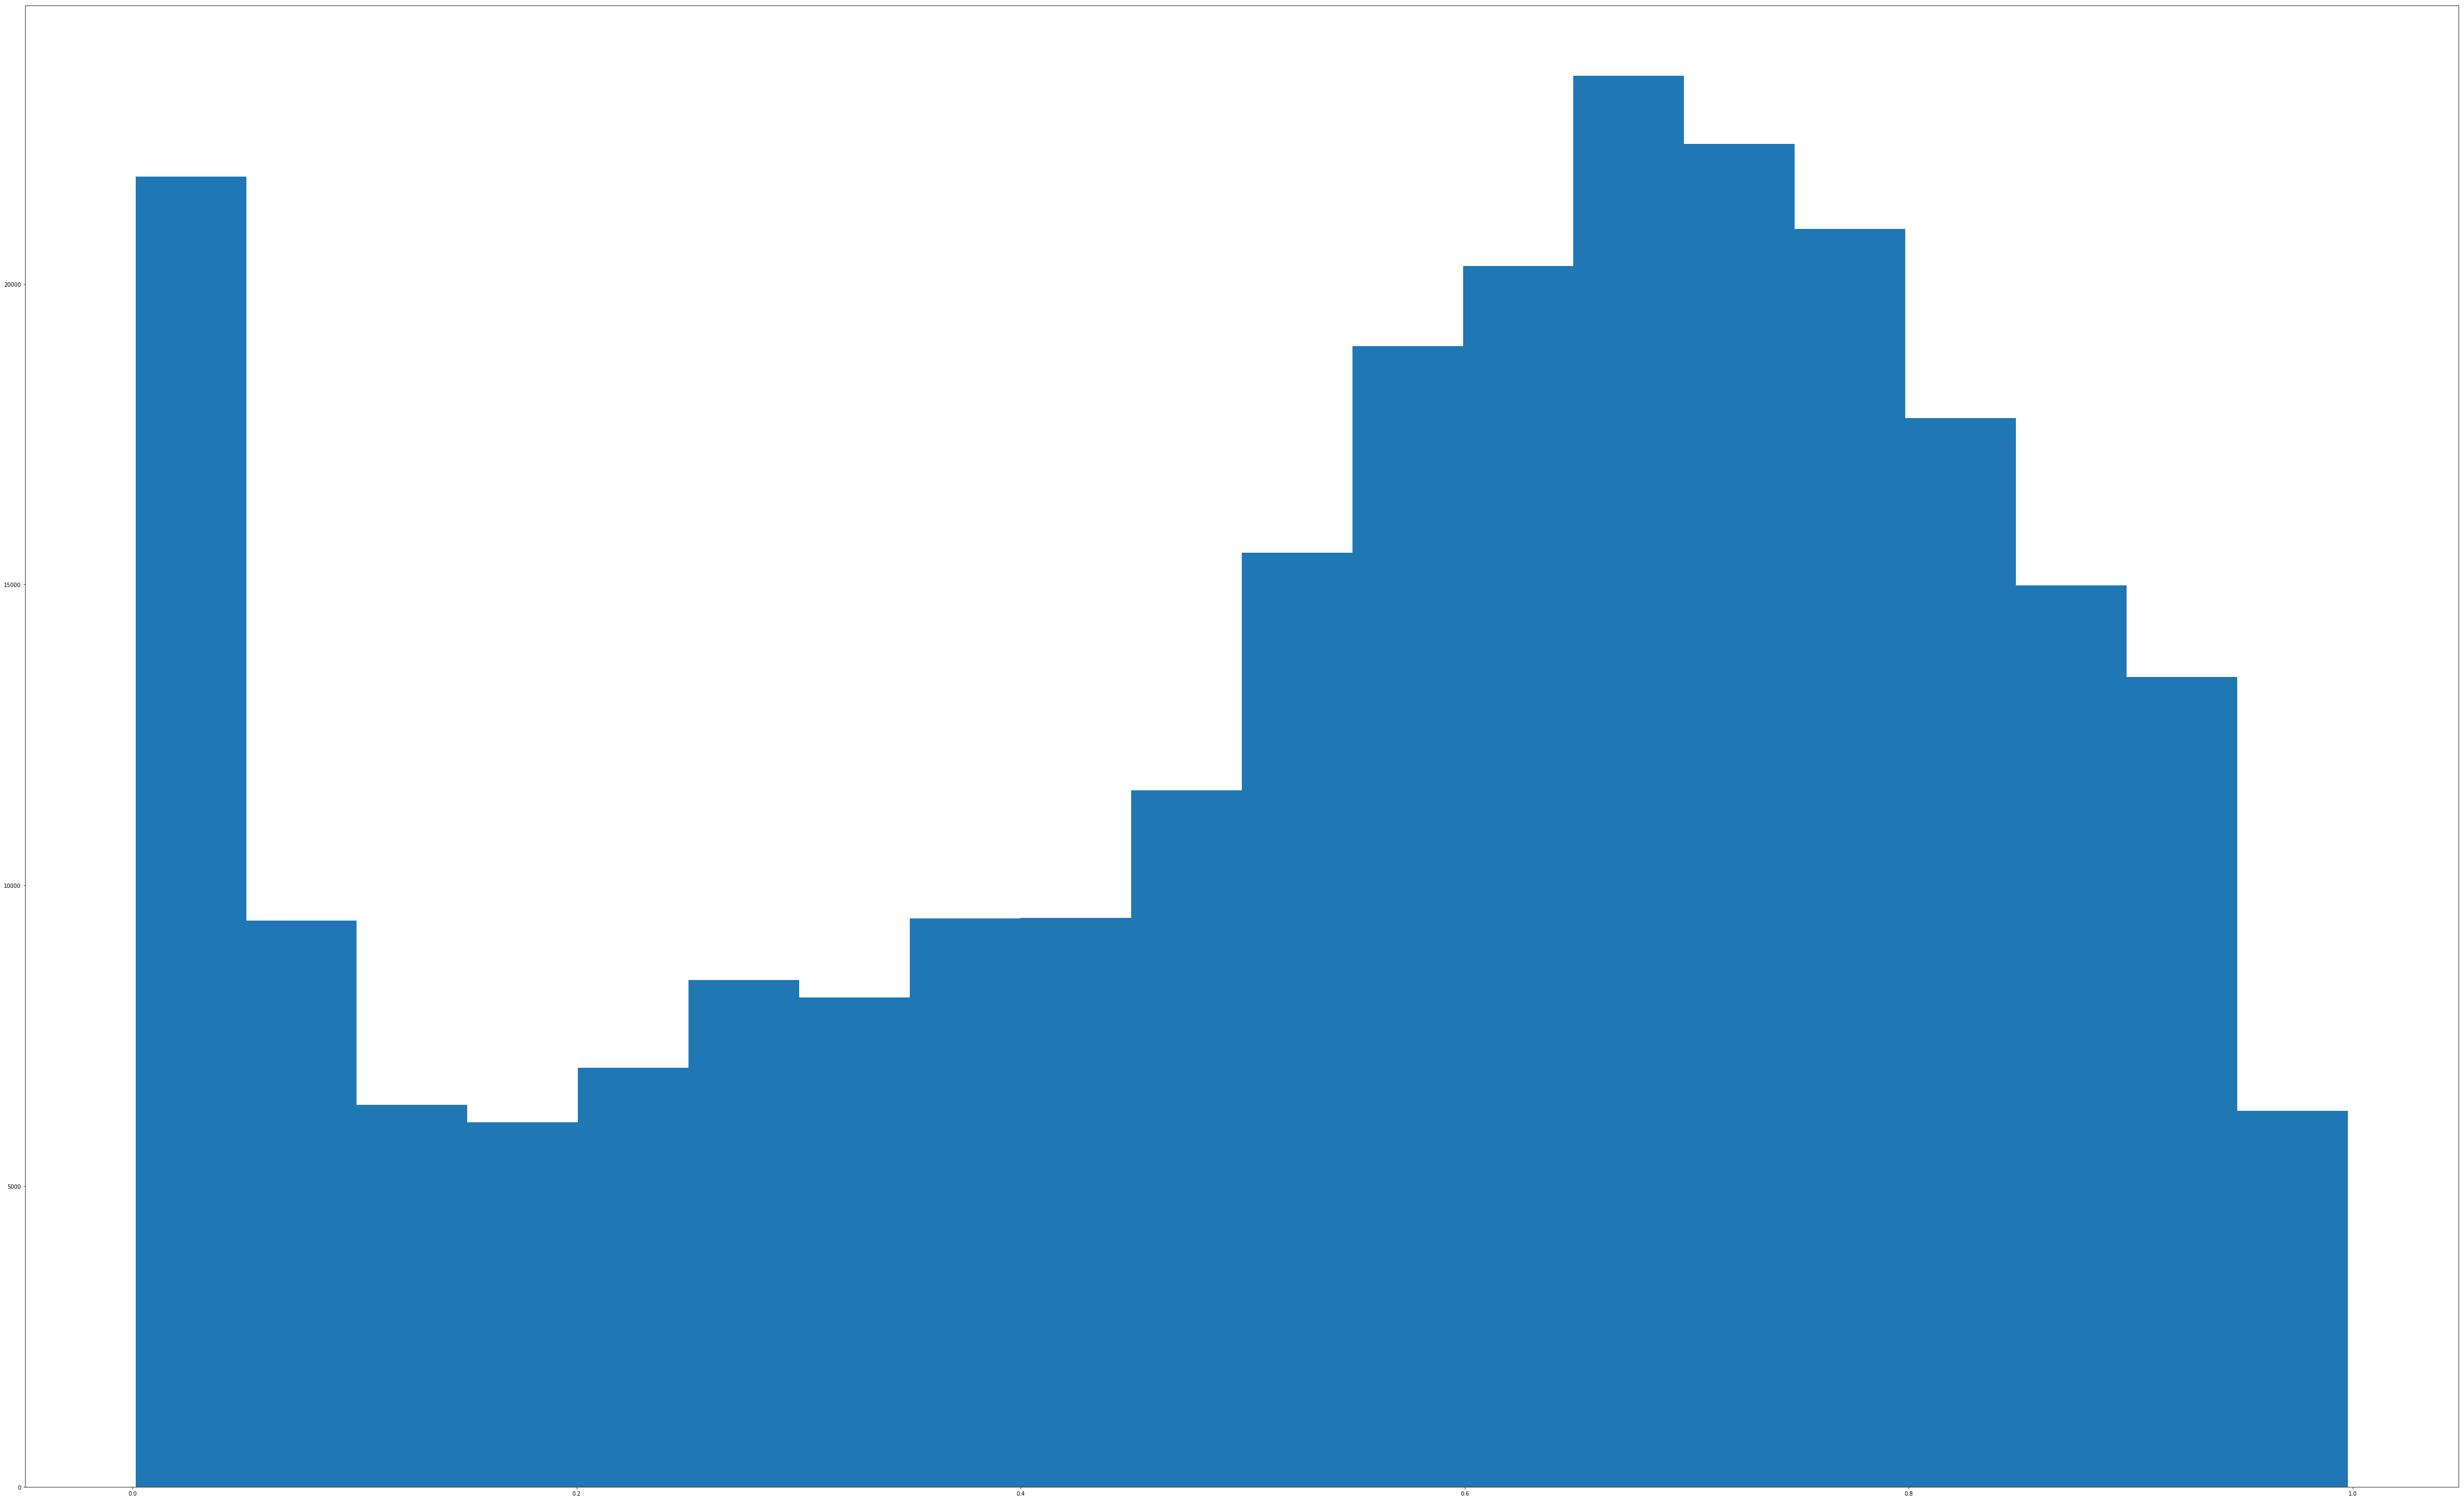

In [47]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [48]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

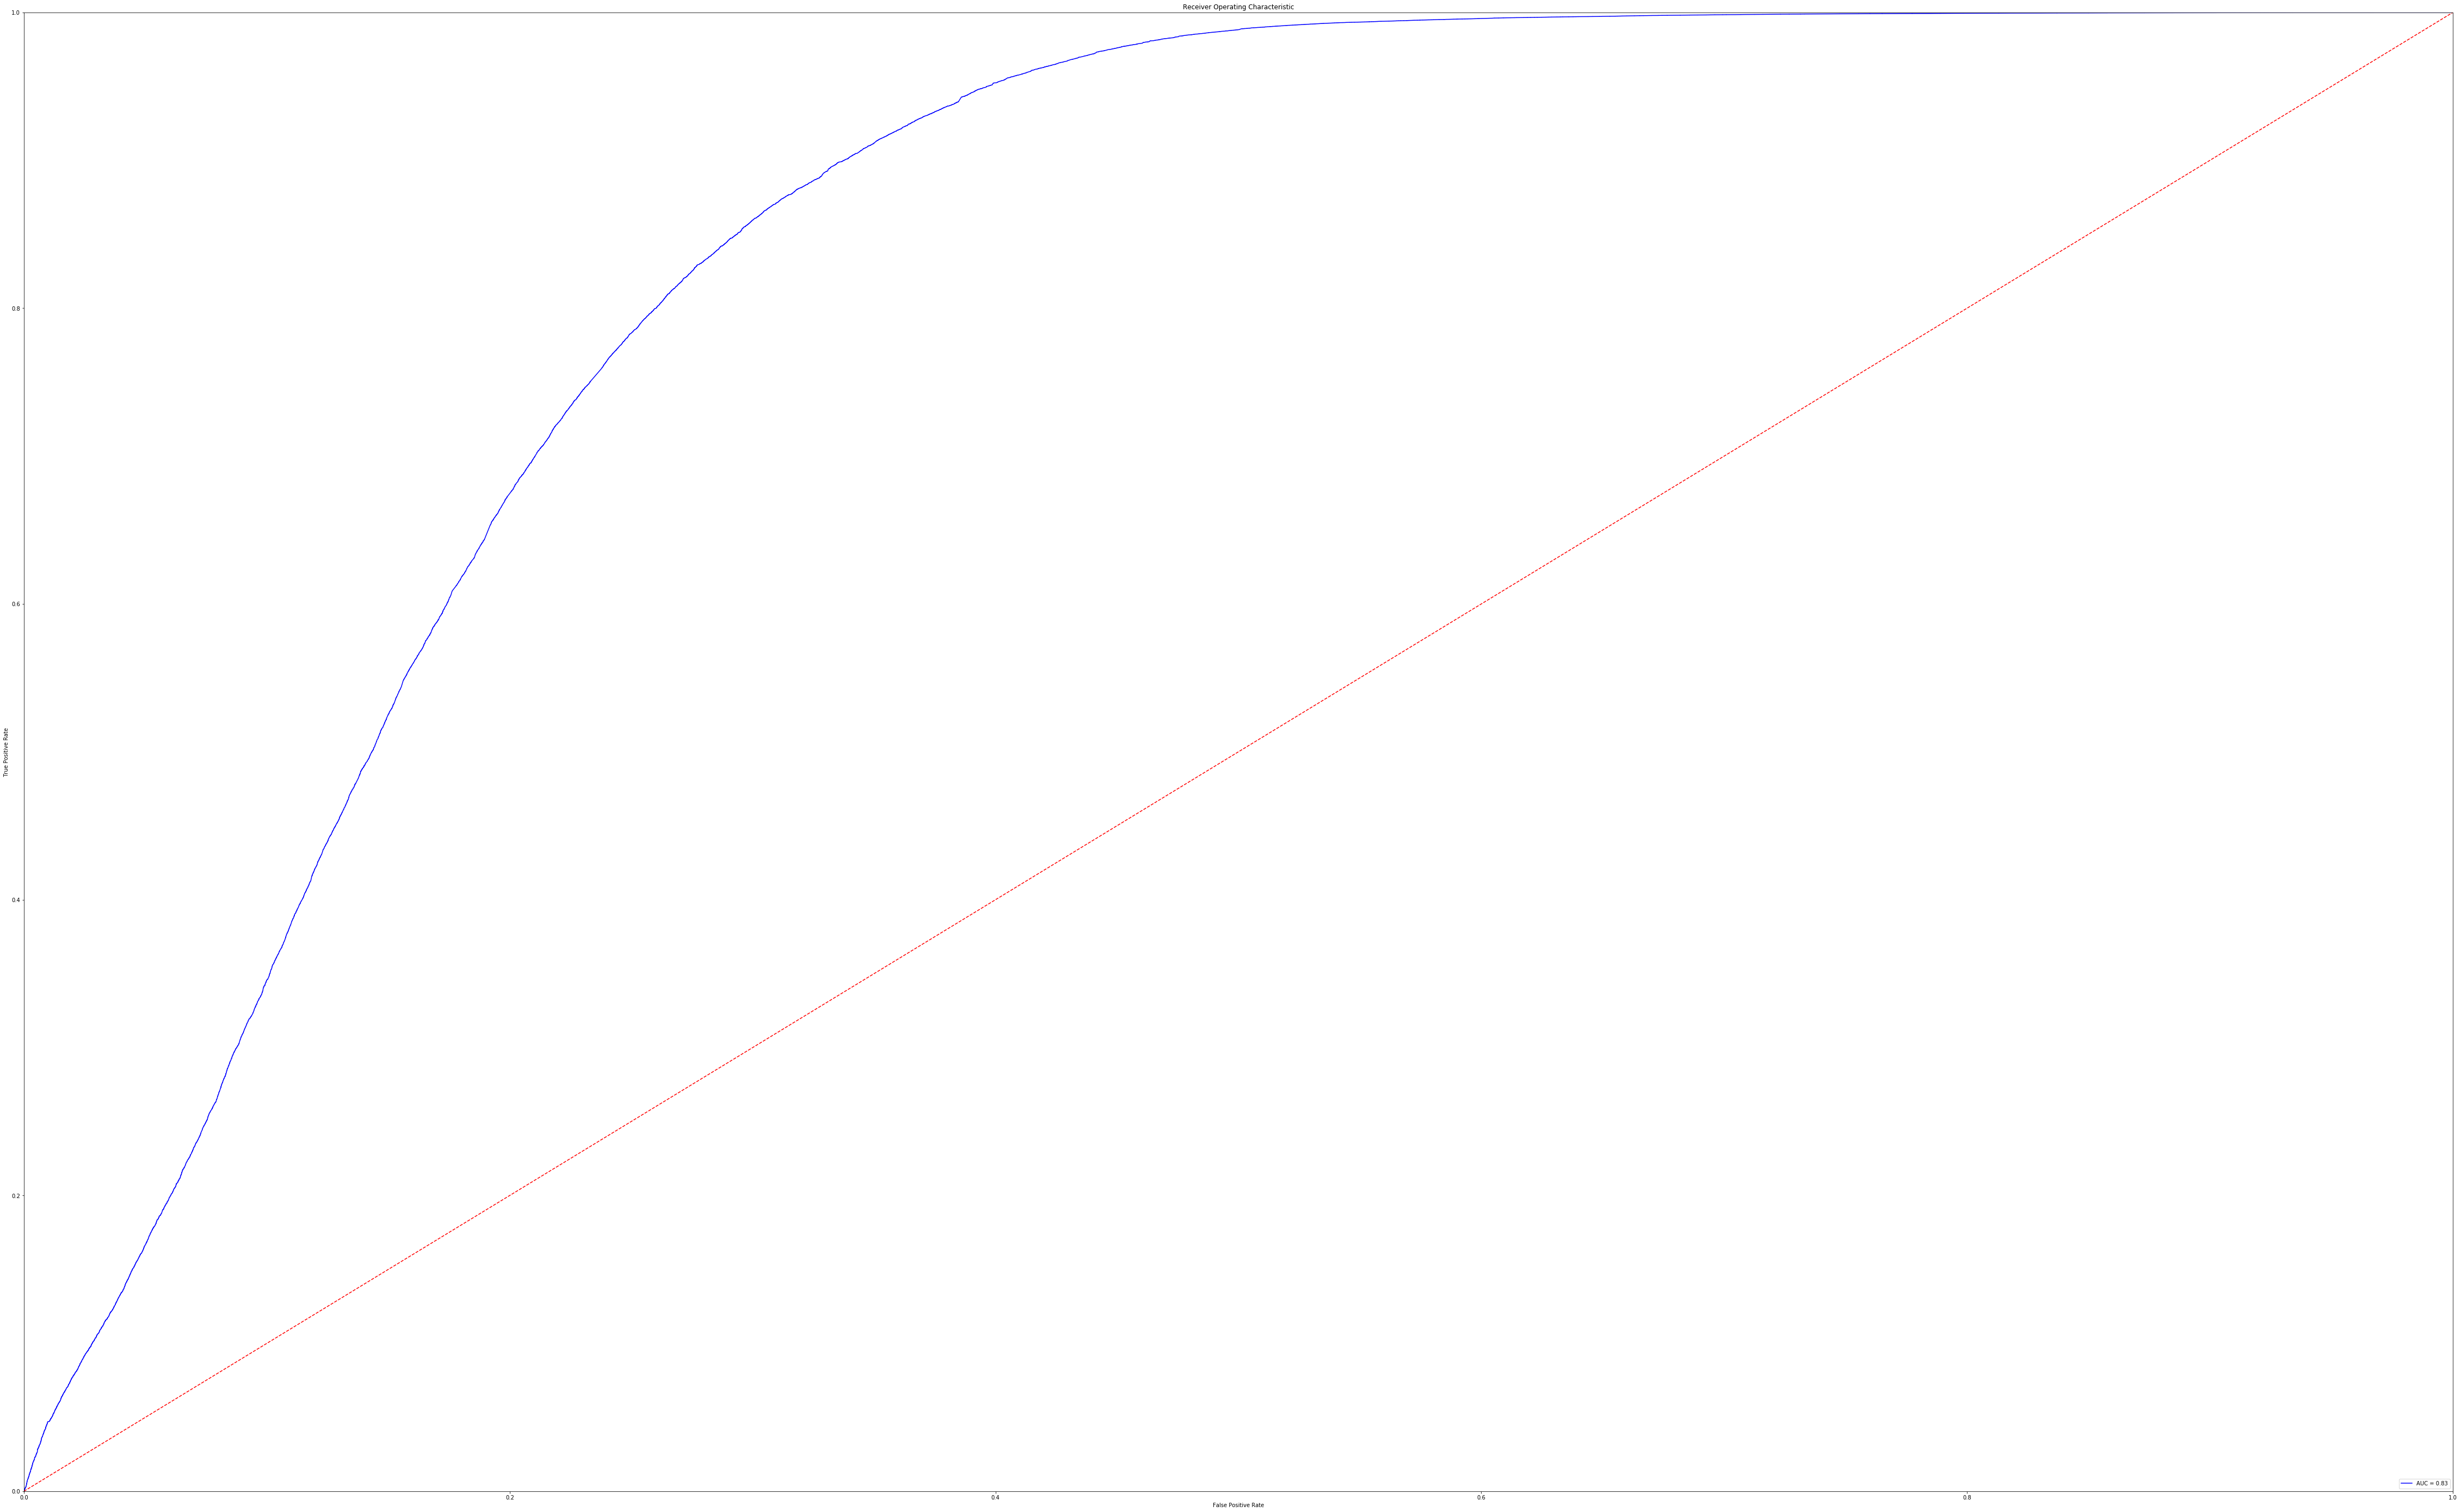

In [49]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("GBDT_HHttWW.pickle.dat", "wb"))

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

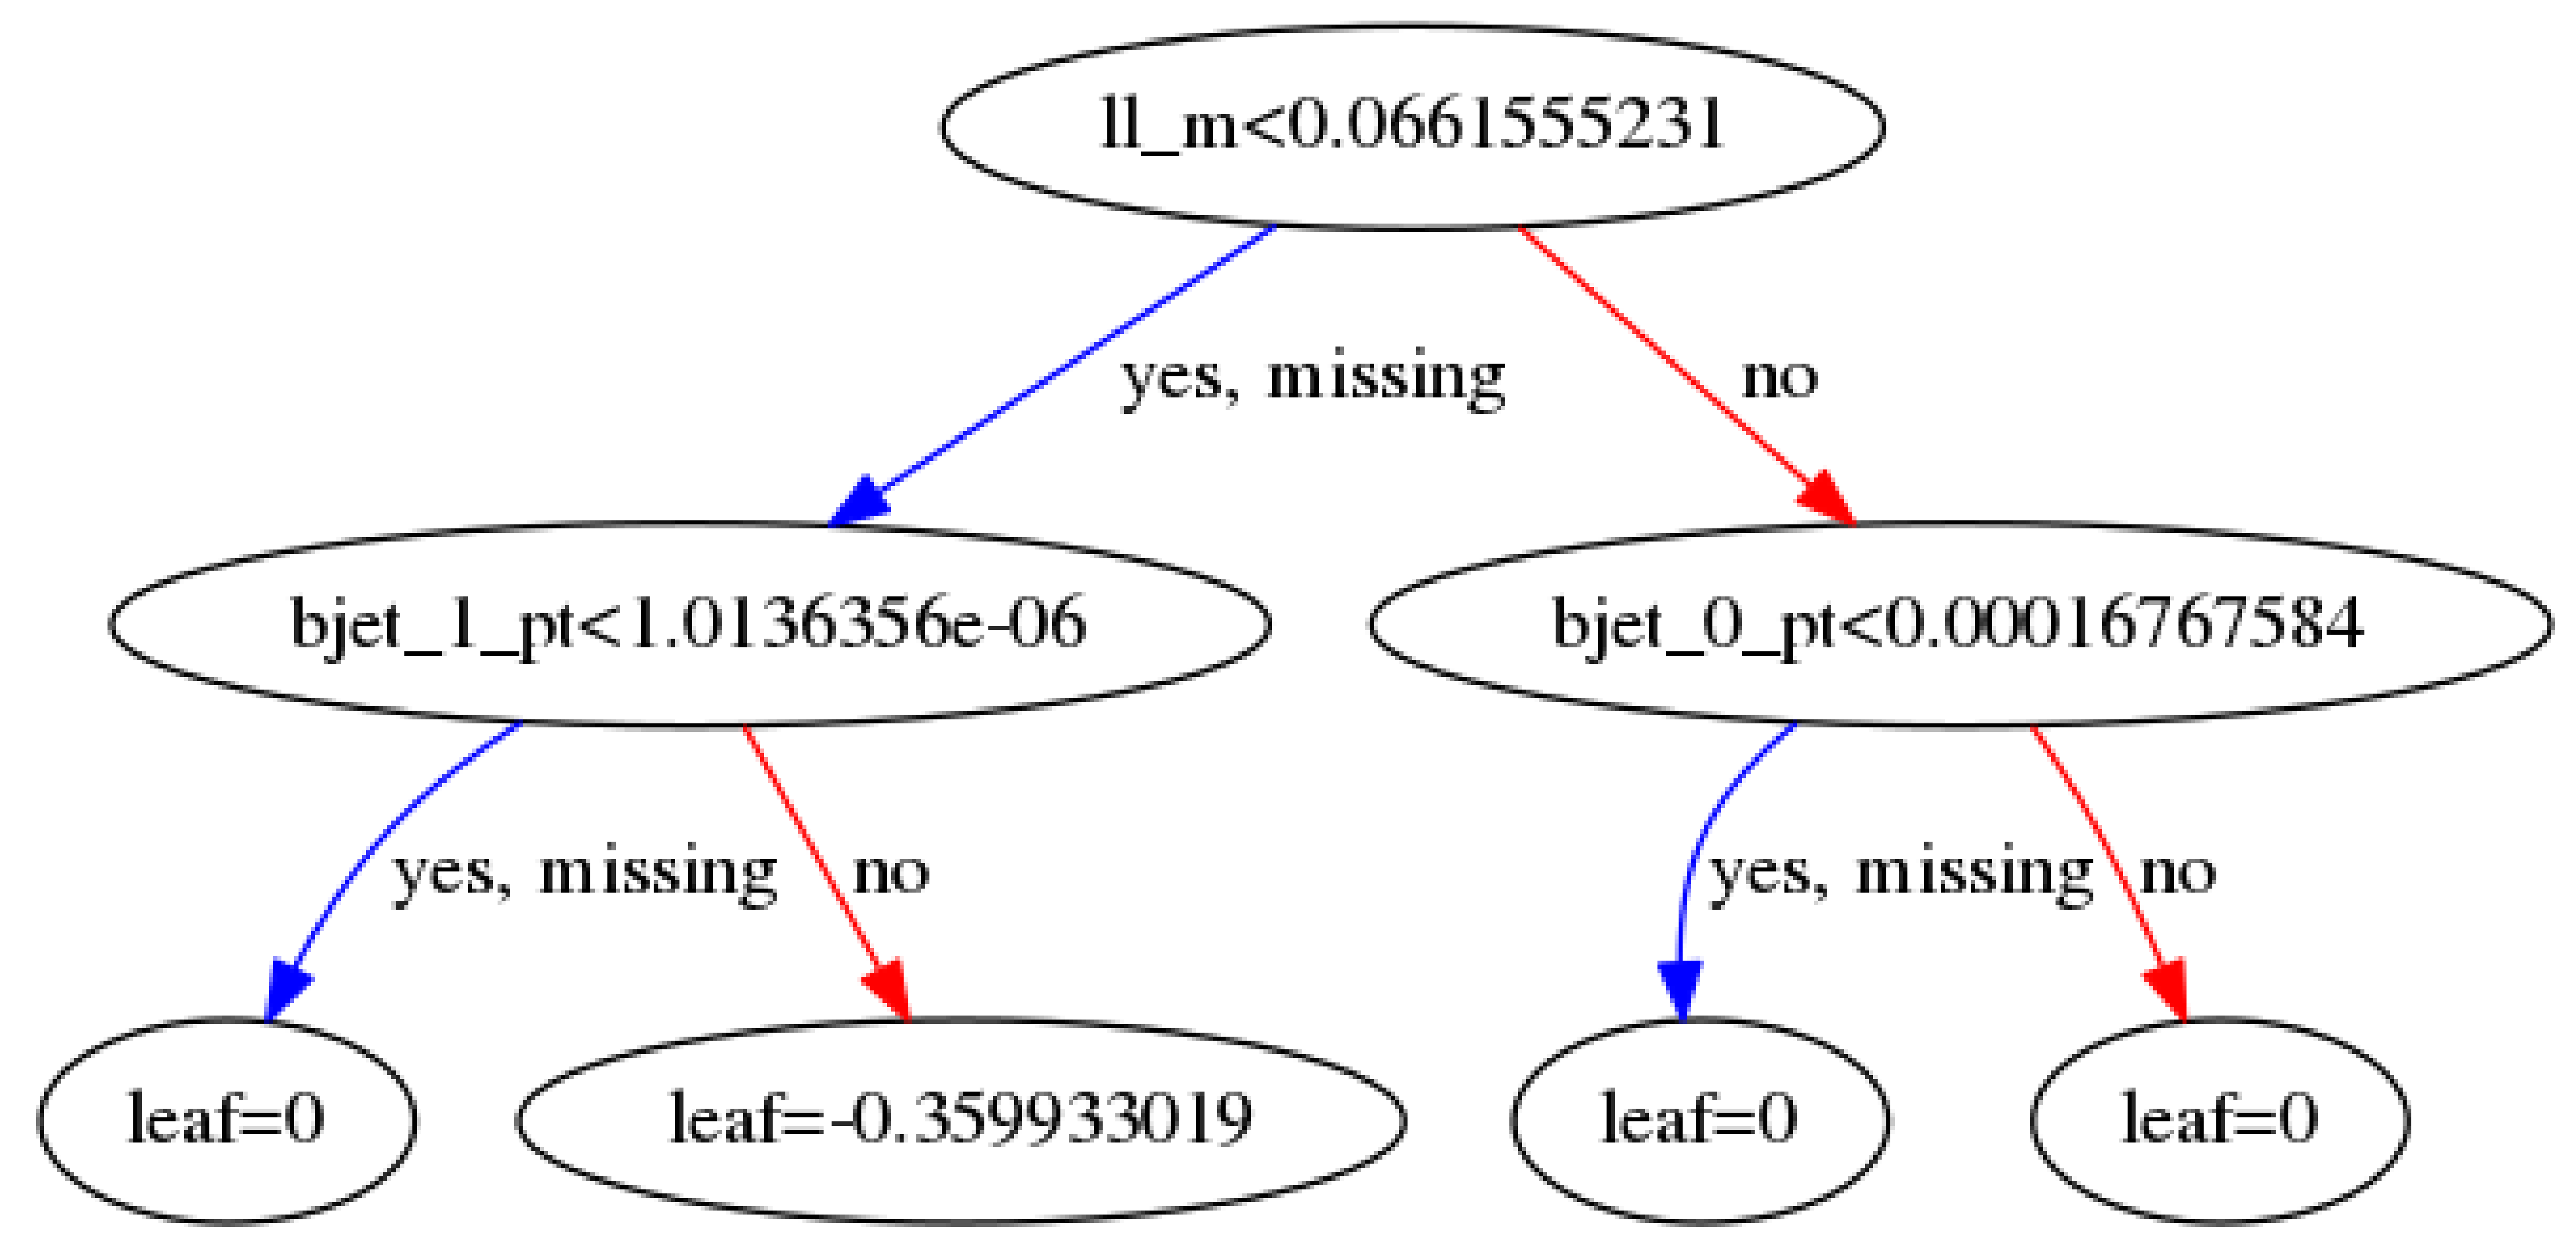

In [41]:
rcParams['figure.figsize'] = 80,50
plot_tree(GBDT, num_trees=1)